<a href="https://colab.research.google.com/github/seunghoona/study-ai-mnist/blob/main/1_3_MNIST_deep_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.optim import Adam

In [2]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# Plot 함수
def plot_acc(train_accs, test_accs, title="default plot", label1='train', label2='test'):
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

[MYCODE] dataset 리팩토링

- dataset 중복코드 제거
- trainset 생성
- testset 생성

In [3]:
transform = transforms.ToTensor()

def get_dataset(train= True, download=True):
    return torchvision.datasets.CIFAR10(
    root='./data',
    train=train,
    download=download,
    transform=transform
)

batch_size = 256
def get_loader(dataset, suffle=True):
    return torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=suffle
)


trainset = get_dataset()
testset = get_dataset(False)

print(f"trainset size: {len(trainset)}")
print(f"testset size: {len(testset)}")

trainloader = get_loader(trainset)
testloader = get_loader(testset, False)

print(f"trainloader size: {len(trainloader)}")
print(f"testloader size: {len(testloader)}")


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
trainset size: 50000
testset size: 10000
trainloader size: 196
testloader size: 40


In [4]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
batch_size, channels, height, width = images.shape

# 이미지 크기와 채널 수 확인
print(f"Image shape: {images.shape}")  # 출력 예: (256, 3, 32, 32)
print(f"Batch size: {batch_size}")
print(f"Number of channels: {channels}")
print(f"Height: {height}")
print(f"Width: {width}")

Image shape: torch.Size([256, 3, 32, 32])
Batch size: 256
Number of channels: 3
Height: 32
Width: 32


In [20]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim, act):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = act()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)

class SigmoidModel(nn.Module):
  def __init__(self, input_dim, n_dim, act):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = act()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    # 활성함수를 삭제
    return self.layer3(x)


[MYCODE] LeakyReLU 변경

- 손실함수를 ReLU 에서 LeakyReLU 변경한다.

In [13]:
model_sgd = Model(width * height * channels, 1024, nn.LeakyReLU).to('cuda')

In [21]:
model_adm = Model(width * height * channels, 1024, nn.LeakyReLU).to('cuda')
model_sigmoid = SigmoidModel(width * height * channels, 1024, nn.Sigmoid).to('cuda')

In [15]:
lr = 0.001
optimizer_sgd = SGD(model_sgd.parameters(), lr=lr)
optimizer_adam = Adam(model_adm.parameters(), lr=lr)
optimizer_sigmoid_adam = Adam(model_sigmoid.parameters(), lr=lr)

In [23]:
cretaition = nn.CrossEntropyLoss()

[LOG] 모델학습 시작

- SGD 모델과 아담 모델을 각각학습하여 각각의 옵티마이저를 이용하여 학습시켰습니다.

In [24]:
n_epochs = 50

# Lists for Accuracy Tracking
train_sgd_accuracies = []
train_adm_accuracies = []
train_sigmoid_accuracies = []

for epoch in range(n_epochs):
  total_sgd_loss = 0.
  total_adam_loss = 0.
  total_sigmoid_adam_loss = 0.
  for data in trainloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # SGD 학습
    model_sgd.zero_grad()
    preds = model_sgd(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_sgd.step()
    total_sgd_loss += loss.item()

    # 아담 학습
    model_adm.zero_grad()
    preds = model_adm(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_adam.step()
    total_adam_loss += loss.item()

    # sigmoid model + adam 학습
    model_sigmoid.zero_grad()
    preds = model_sigmoid(inputs)
    loss = cretaition(preds, labels)
    loss.backward()
    optimizer_sigmoid_adam.step()
    total_sigmoid_adam_loss += loss.item()

  # Epoch 종료 후 정확도 계산
  train_sgd_accuracy = accuracy(model_sgd, trainloader)
  train_adm_accuracy = accuracy(model_adm, trainloader)
  train_sigmoid_accuracy = accuracy(model_sigmoid, trainloader)

  train_sgd_accuracies.append(train_sgd_accuracy)
  train_adm_accuracies.append(train_adm_accuracy)
  train_sigmoid_accuracies.append(train_sigmoid_accuracy)

  print(f"Epoch SGD {epoch + 1}/{n_epochs}, Loss: {total_sgd_loss / len(trainloader):.4f}, Train Acc: {train_sgd_accuracy:.4f}")
  print(f"Epoch ADM {epoch + 1}/{n_epochs}, Loss: {total_adam_loss / len(trainloader):.4f}, Train Acc: {train_adm_accuracy:.4f}")
  print(f"Epoch SIGMOID + ADM {epoch + 1}/{n_epochs}, Loss: {total_sigmoid_adam_loss / len(trainloader):.4f}, Train Acc: {train_sigmoid_accuracy:.4f}")

# 모델 저장 경로
model_sgd_path = "model_sgd.pth"
model_adam_path = "model_adam.pth"

# SGD 모델 저장
torch.save(model_sgd.state_dict(), model_sgd_path)
print(f"SGD Model saved to {model_sgd_path}")

# Adam 모델 저장
torch.save(model_adm.state_dict(), model_adam_path)
print(f"Adam Model saved to {model_adam_path}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


[MYCODE] SGD 와  ADAM 학습된 각각의 에포츠 활성함수  대해 플로팅

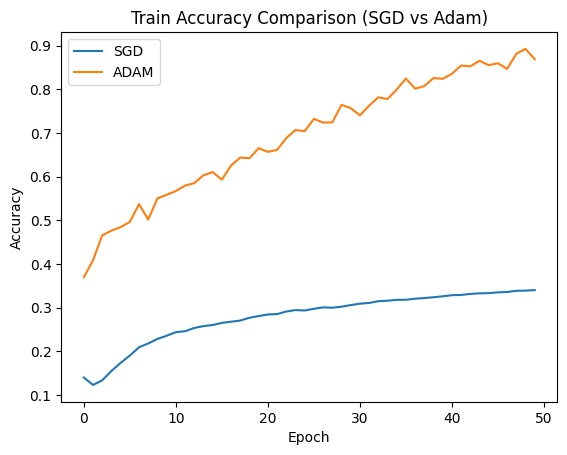

In [40]:
# 정확도 Plot
plot_acc(train_sgd_accuracies, train_adm_accuracies,"Train Accuracy Comparison (SGD vs Adam)", 'SGD', 'ADAM')